In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read Data

In [2]:
df = pd.read_csv('../data/raw/train_period_1.csv')
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [3]:
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44084 entries, 0 to 44083
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         44084 non-null  float64
 1   Age                44084 non-null  float64
 2   Gender             44084 non-null  object 
 3   Tenure             44084 non-null  float64
 4   Usage Frequency    44084 non-null  float64
 5   Support Calls      44084 non-null  float64
 6   Payment Delay      44084 non-null  float64
 7   Subscription Type  44084 non-null  object 
 8   Contract Length    44084 non-null  object 
 9   Total Spend        44084 non-null  float64
 10  Last Interaction   44084 non-null  float64
 11  Churn              44084 non-null  float64
dtypes: float64(9), object(3)
memory usage: 4.0+ MB


## Processing

In [5]:
df_processed = df.copy()

### Handle Mising Values

In [6]:
print(df_processed.isnull().sum())

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


In [7]:
# Drop rows with missing values
df_processed = df_processed.dropna()

In [8]:
print(df_processed.isnull().sum())

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


### Handle Duplicated Value

In [9]:
# Count how many rows are duplicates based on CustomerID
duplicate_count = df_processed.duplicated(subset=['CustomerID']).sum()
print(f"Number of duplicate CustomerIDs: {duplicate_count}")

# View the actual duplicate rows
duplicates = df_processed[df_processed.duplicated(subset=['CustomerID'], keep=False)]
print(duplicates.sort_values(by='CustomerID').head())

Number of duplicate CustomerIDs: 0
Empty DataFrame
Columns: [CustomerID, Age, Gender, Tenure, Usage Frequency, Support Calls, Payment Delay, Subscription Type, Contract Length, Total Spend, Last Interaction, Churn]
Index: []


In [10]:
# Keep the first occurrence and remove subsequent ones
df_processed = df_processed.drop_duplicates(subset=['CustomerID'], keep='first')

### Convert CustomerID to string

In [11]:
df_processed['CustomerID'] = df_processed['CustomerID'].astype("int64")

In [12]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44084 entries, 0 to 44083
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         44084 non-null  int64  
 1   Age                44084 non-null  float64
 2   Gender             44084 non-null  object 
 3   Tenure             44084 non-null  float64
 4   Usage Frequency    44084 non-null  float64
 5   Support Calls      44084 non-null  float64
 6   Payment Delay      44084 non-null  float64
 7   Subscription Type  44084 non-null  object 
 8   Contract Length    44084 non-null  object 
 9   Total Spend        44084 non-null  float64
 10  Last Interaction   44084 non-null  float64
 11  Churn              44084 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 4.0+ MB


### Convert float columns that should be integers

In [13]:
int_columns = ['Age', 'Tenure', 'Support Calls', 'Last Interaction']
for col in int_columns:
    df_processed[col] = df_processed[col].astype(int)

### Handle categorical variables

In [14]:
categorical_features  = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_features :
    print(f"{col}: {df_processed[col].unique()}")

Gender: ['Female' 'Male']
Subscription Type: ['Standard' 'Basic' 'Premium']
Contract Length: ['Annual' 'Monthly' 'Quarterly']


In [15]:
# We use options A because the models we train is Random Forest

In [16]:
# Option A: One-hot encoding (for tree-based models)
df_encoded = pd.get_dummies(df_processed, columns=categorical_features , drop_first=True)

In [17]:
# OR Option B: Label encoding (for linear models)
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])
#     label_encoders[col] = le

### Check outliers

In [18]:
numerical_features  = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 
                  'Payment Delay', 'Total Spend']

In [19]:
for col in numerical_features :
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df_processed)*100:.2f}%)")

Age: 0 outliers (0.00%)
Tenure: 0 outliers (0.00%)
Usage Frequency: 0 outliers (0.00%)
Support Calls: 0 outliers (0.00%)
Payment Delay: 0 outliers (0.00%)
Total Spend: 0 outliers (0.00%)


In [20]:
# Because the dataset don't have outliers, we will not remove any rows
# If needed, we could use:
# Handle outliers (if any)
# Option 1: Cap outliers
# for col in numerical_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[col] = np.clip(df[col], lower_bound, upper_bound)

# Option 2: Remove outliers
# for col in numerical_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]

### Create Feature 

In [21]:
df_processed['Tenure_Age_Ratio'] = df_processed['Tenure'] / (df_processed['Age'] + 1)
df_processed['Spend_per_Usage'] = df_processed['Total Spend'] / (df_processed['Usage Frequency'] + 1)
df_processed['Support_Calls_per_Tenure'] = df_processed['Support Calls'] / (df_processed['Tenure'] + 1)

In [22]:
# Create customer segments based on spending
df_processed['Spending_Group'] = pd.qcut(df_processed['Total Spend'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [23]:
# Create tenure groups
df_processed['Tenure_Group'] = pd.cut(df_processed['Tenure'], 
                                      bins=[0, 12, 24, 36, 100], 
                                      labels=['<1yr', '1-2yr', '2-3yr', '3+yr'])

# Add categorical features to the list
categorical_features.extend(['Spending_Group', 'Tenure_Group'])
df_processed.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,Tenure_Age_Ratio,Spend_per_Usage,Support_Calls_per_Tenure,Spending_Group,Tenure_Group
0,2,30,Female,39,14.0,5,18.0,Standard,Annual,932.0,17,1.0,1.258065,62.133333,0.125000,Very High,3+yr
1,3,65,Female,49,1.0,10,8.0,Basic,Monthly,557.0,6,1.0,0.742424,278.500000,0.200000,High,3+yr
2,4,55,Female,14,4.0,6,18.0,Basic,Quarterly,185.0,3,1.0,0.250000,37.000000,0.400000,Low,1-2yr
3,5,58,Male,38,21.0,7,7.0,Standard,Monthly,396.0,29,1.0,0.644068,18.000000,0.179487,Medium,3+yr
4,6,23,Male,32,20.0,5,8.0,Basic,Monthly,617.0,20,1.0,1.333333,29.380952,0.151515,High,2-3yr


In [24]:
import os

out_dir = '../data/processed'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'df_processed.csv')

df_processed.to_csv(out_path, index=False)
print(f"Exported df_processed to {out_path}")

Exported df_processed to ../data/processed/df_processed.csv


## EDA

([<matplotlib.axis.XTick at 0x78f1c54d7770>,
 [Text(0, 0, 'Not Churned'), Text(1, 0, 'Churned')])

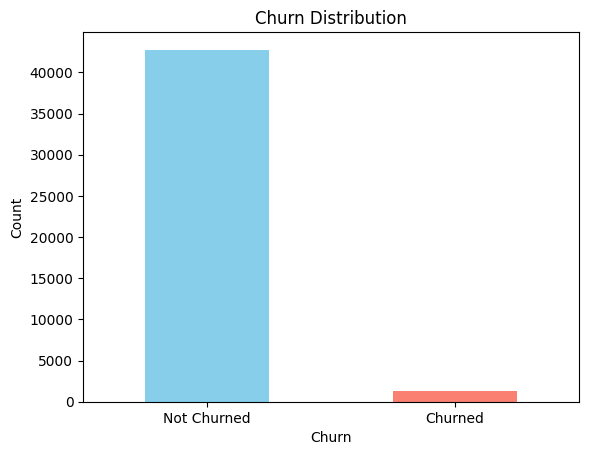

In [25]:
plt.plot()
df['Churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Churned', 'Churned'], rotation=0)

Text(0.5, 1.0, 'Age Distribution by Churn')

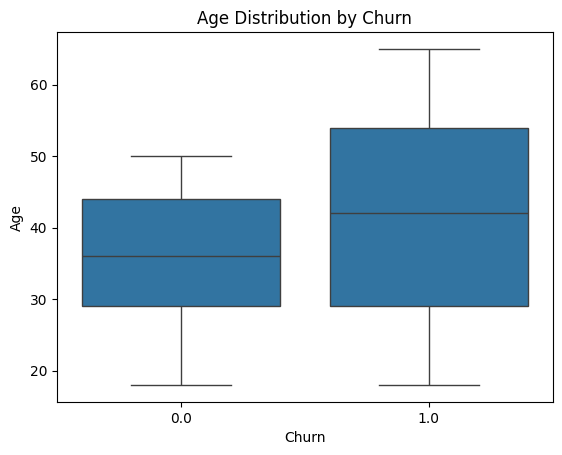

In [26]:
plt.plot()
sns.boxplot(x='Churn', y='Age', data=df)
plt.title('Age Distribution by Churn')

Text(0.5, 1.0, 'Tenure Distribution by Churn')

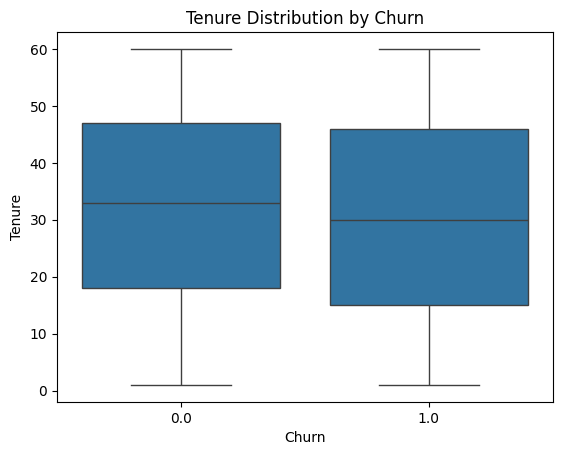

In [27]:
plt.plot()
sns.boxplot(x='Churn', y='Tenure', data=df)
plt.title('Tenure Distribution by Churn')

Text(0.5, 1.0, 'Correlation Heatmap')

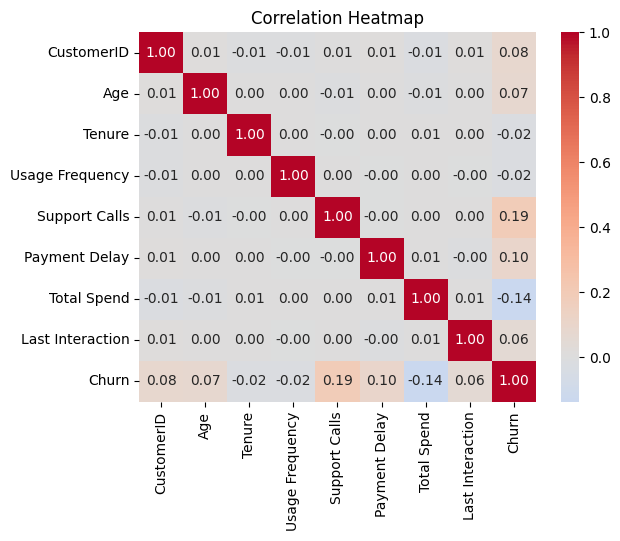

In [28]:
plt.plot()
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Correlation Heatmap')

Text(0.5, 1.0, 'Payment Delay by Churn')

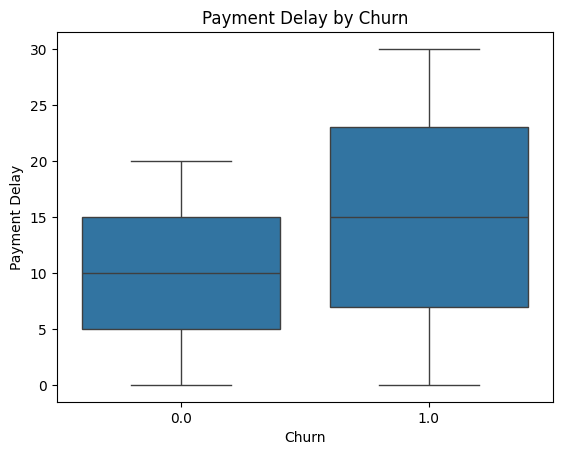

In [29]:
plt.plot()
sns.boxplot(x='Churn', y='Payment Delay', data=df)
plt.title('Payment Delay by Churn')

Text(0.5, 1.0, 'Total Spend by Churn')

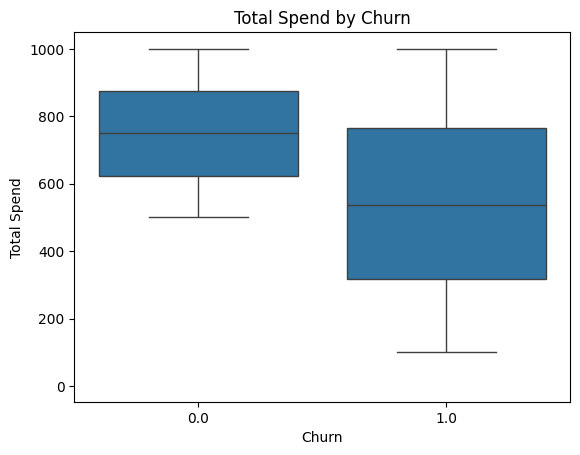

In [30]:
plt.plot(2, 3, 6)
sns.boxplot(x='Churn', y='Total Spend', data=df)
plt.title('Total Spend by Churn')

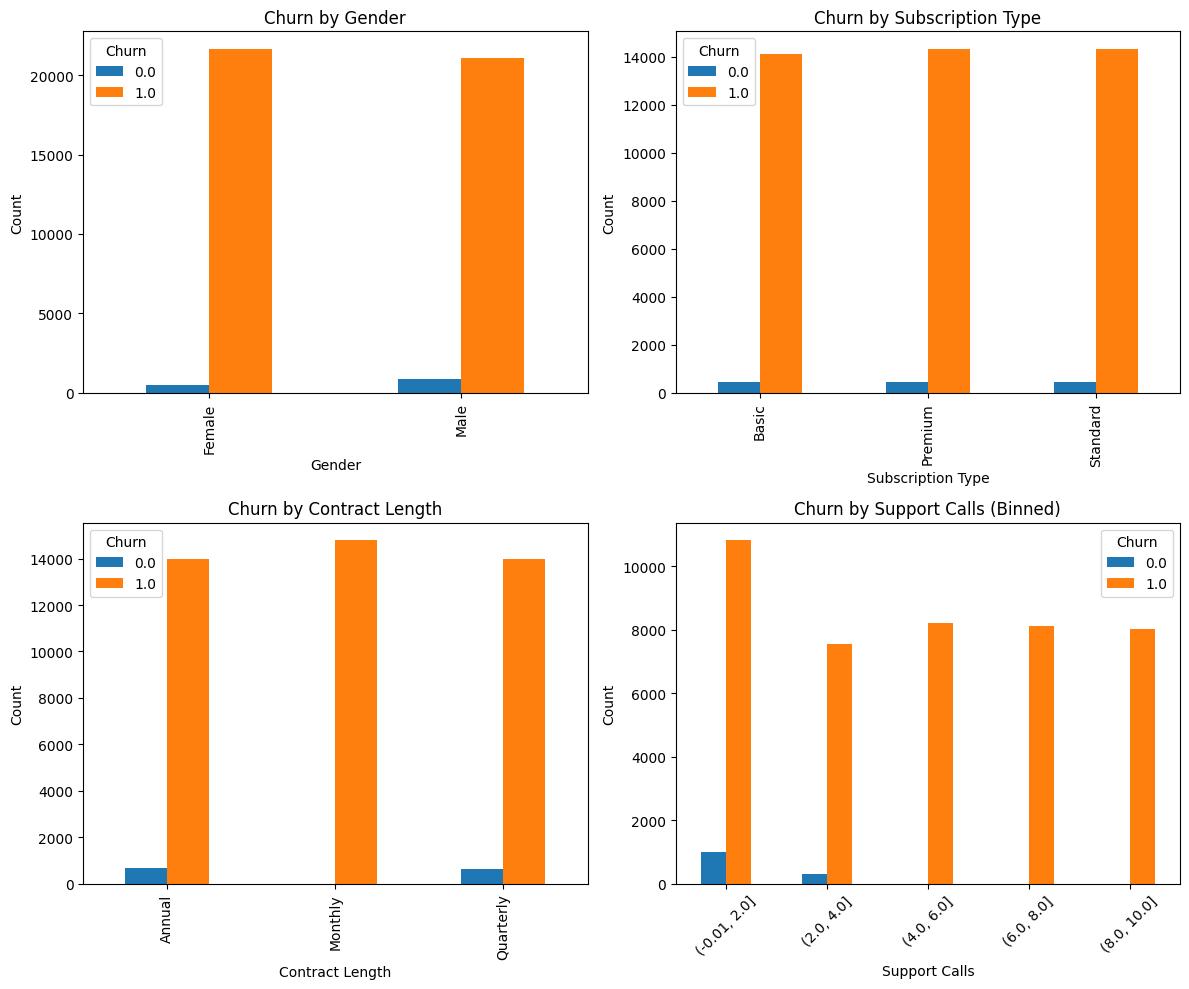

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Gender vs Churn
gender_churn = pd.crosstab(df['Gender'], df['Churn'])
gender_churn.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Churn by Gender')
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Count')

# Subscription Type vs Churn
sub_churn = pd.crosstab(df['Subscription Type'], df['Churn'])
sub_churn.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Churn by Subscription Type')
axes[0, 1].set_xlabel('Subscription Type')
axes[0, 1].set_ylabel('Count')

# Contract Length vs Churn
contract_churn = pd.crosstab(df['Contract Length'], df['Churn'])
contract_churn.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Churn by Contract Length')
axes[1, 0].set_xlabel('Contract Length')
axes[1, 0].set_ylabel('Count')

# Support Calls vs Churn
support_churn = pd.crosstab(pd.cut(df['Support Calls'], bins=5), df['Churn'])
support_churn.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Churn by Support Calls (Binned)')
axes[1, 1].set_xlabel('Support Calls')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()